In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.metrics import fbeta_score, make_scorer

In [11]:
# ------------------------------
# 1. Data Splitting (Assuming dataset is already clean)
# ------------------------------
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.drop(columns=['EmployeeCount', 'StandardHours', 'EmployeeNumber'], inplace=True)
df.drop_duplicates(inplace=True)

# Convert Attrition to binary: 'Yes' → 1, 'No' → 0.
df["Attrition"] = df["Attrition"].map({'Yes': 1, 'No': 0})

X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [12]:
display(X_train)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,47,Travel_Rarely,1225,Sales,2,4,Life Sciences,2,Female,47,...,3,3,3,29,2,3,3,2,1,2
1,22,Travel_Rarely,594,Research & Development,2,1,Technical Degree,3,Male,100,...,3,3,1,3,2,3,2,1,2,1
2,46,Travel_Rarely,406,Sales,3,1,Marketing,1,Male,52,...,3,4,1,23,3,3,12,9,4,9
3,25,Travel_Rarely,622,Sales,13,1,Medical,2,Male,40,...,3,3,0,7,1,3,7,4,0,6
4,43,Travel_Frequently,1001,Research & Development,9,5,Medical,4,Male,72,...,3,2,1,10,3,3,8,7,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,23,Travel_Rarely,427,Sales,7,3,Life Sciences,3,Male,99,...,4,2,1,3,2,3,3,2,0,2
1172,38,Travel_Rarely,1009,Sales,2,2,Life Sciences,2,Female,31,...,3,4,1,11,3,3,7,7,1,7
1173,22,Travel_Rarely,217,Research & Development,8,1,Life Sciences,2,Male,94,...,3,1,1,4,3,2,4,3,1,1
1174,36,Travel_Rarely,430,Research & Development,2,4,Other,4,Female,73,...,4,4,1,15,2,3,1,0,0,0


In [13]:
# ------------------------------
# 2. Define Column Groups & Preprocessing Options
# ------------------------------
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Columns to keep as ordinal (already integers)
ordinal_cols = ['Education', 'EnvironmentSatisfaction', 'JobInvolvement',
                'JobLevel', 'JobSatisfaction', 'PerformanceRating',
                'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']

# For numeric columns, we want to apply log transform only on those that are not ordinal.
numeric_to_transform = [col for col in numeric_cols if col not in ordinal_cols]

# For categorical columns, separate BusinessTravel so we can experiment with its encoding.
business_travel = ['BusinessTravel']
other_cat_cols = [col for col in categorical_cols if col not in business_travel]

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import pandas as pd

class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, mapping=None):
        # Default mapping if none is provided.
        if mapping is None:
            mapping = {'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2}
        self.mapping = mapping
        
    def fit(self, X, y=None):
        # Optionally, you could store the unique categories here.
        # For now, simply mark the encoder as fitted.
        self.fitted_ = True
        return self
    
    def transform(self, X):
        # Ensure the transformer has been fitted.
        if not hasattr(self, 'fitted_'):
            raise ValueError("This CustomOrdinalEncoder instance is not fitted yet. Call 'fit' before using this method.")
        
        # If X is a numpy array and has shape (n_samples, 1), flatten it.
        if isinstance(X, np.ndarray):
            if X.ndim == 2 and X.shape[1] == 1:
                s = pd.Series(X.ravel())
                mapped = s.map(self.mapping)
                if mapped.isnull().any():
                    raise ValueError("Some values were not found in the mapping")
                return mapped.values.reshape(-1, 1)
            else:
                raise ValueError("Expected a 2D array with a single column")
        else:
            # If X is a pandas DataFrame or Series.
            if isinstance(X, pd.DataFrame):
                if X.shape[1] == 1:
                    s = X.iloc[:, 0]
                    mapped = s.map(self.mapping)
                    if mapped.isnull().any():
                        raise ValueError("Some values were not found in the mapping")
                    return mapped.values.reshape(-1, 1)
                else:
                    # If there are multiple columns, apply mapping on each.
                    return X.apply(lambda col: col.map(self.mapping)).values
            elif isinstance(X, pd.Series):
                mapped = X.map(self.mapping)
                if mapped.isnull().any():
                    raise ValueError("Some values were not found in the mapping")
                return mapped.values.reshape(-1, 1)
            else:
                raise ValueError("Input type not recognized. Expected numpy array or pandas DataFrame/Series.")


In [15]:
# ------------------------------
# 3. Build Preprocessing Pipelines
# ------------------------------
# Numeric pipeline: we allow toggling log transform.
# The 'log' step will be controlled via the parameter grid.
num_pipeline =  Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p, validate=True)),  # can be set to 'passthrough'
    ('scaler', StandardScaler())  # can switch to MinMaxScaler via grid
])
# We will apply the numeric pipeline only to numeric_to_transform columns.

# For ordinal columns, no transformation is needed.
ordinal_pipeline = 'passthrough'

# For BusinessTravel, we experiment with either one-hot encoding or ordinal encoding.
bus_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))  # parameter grid can swap in OrdinalEncoder()
])

# For other categorical features, use one-hot encoding.
other_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

# Build the overall preprocessor via ColumnTransformer.
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_to_transform),
    ('ord', ordinal_pipeline, ordinal_cols),
    ('bus', bus_pipeline, business_travel),
    ('other_cat', other_cat_pipeline, other_cat_cols)
])


In [16]:
# ------------------------------
# 4. Define Feature Selection Options
# ------------------------------
# Define three feature selection strategies.
feat_sel_rfe = RFE(estimator=LogisticRegression(max_iter=500, random_state=42), n_features_to_select=10)
feat_sel_lasso = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
feat_sel_tree = SelectFromModel(RandomForestClassifier(random_state=42), threshold='median')


In [17]:
import copy
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone
from sklearn.metrics import fbeta_score, make_scorer

# Create an F2 scorer: beta=2 gives more weight to recall.
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define the base models with fixed (default) hyperparameters.
base_models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(max_iter=500, random_state=42)
}

# Define a parameter grid that tunes only the pipeline steps.
pipeline_param_grid = {
    'preprocessor__num__log': [FunctionTransformer(np.log1p, validate=True), 'passthrough'],
    'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
    'preprocessor__bus__encoder': [OneHotEncoder(drop='first'), CustomOrdinalEncoder()],
    'feat_sel': ['passthrough', feat_sel_rfe, feat_sel_lasso, feat_sel_tree]
}

# Dictionary to store the best pipeline for each base model (without classifier hyperparameter tuning)
best_pipeline_nonhyper = {}

# Loop over each base model
for model_name, model in base_models.items():
    print(f"\nTuning pipeline steps for {model_name}...")
    
    # Create a pipeline with the current base model and fixed classifier settings.
    pipeline_model = ImbPipeline([
        ('preprocessor', clone(preprocessor)),  # clone to avoid side-effects
        ('smote', SMOTE(random_state=42)),
        ('feat_sel', 'passthrough'),              # placeholder; will be tuned
        ('classifier', model)                     # fixed classifier for now
    ])
    
    # Perform grid search over only the pipeline steps using the F2 scorer.
    grid_search_model = GridSearchCV(
        pipeline_model,
        param_grid=pipeline_param_grid,
        cv=5,
        scoring=f2_scorer,  # Use F2 as the scoring metric
        n_jobs=-1,
        verbose=2
    )
    
    grid_search_model.fit(X_train, y_train)
    
    # Store the best pipeline for the current model.
    best_pipeline = grid_search_model.best_estimator_
    best_pipeline_nonhyper[model_name] = best_pipeline
    print(f"Best pipeline for {model_name}: {grid_search_model.best_params_}")



Tuning pipeline steps for LogisticRegression...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   0.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   0.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   0.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=St

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.2s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, prep

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.1s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.1s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.0s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.2s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.0s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.8s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   0.9s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=passthrough, 

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.0s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.1s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=passthrough, preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.3s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.2s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.5s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, 

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.2s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0,

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.2s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Tr

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.3s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.3s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.2s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.0s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, 

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.2s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.1s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'l

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegres

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.0s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel':

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.2s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                           

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__enco

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.7s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear')), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
           

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.2s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(es

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='fi

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=OneHotEncoder(drop='first'), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransf

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=StandardScaler(); total time=   1.6s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=FunctionTransformer(func=<ufunc 'log1p'>, validate=True), preprocessor__num__scaler=MinMaxScaler(); total time=   1.4s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(ma

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.5s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.6s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=StandardScaler(); total time=   1.5s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5

[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.3s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.2s
[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rare

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END feat_sel=SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median'), preprocessor__bus__encoder=CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), preprocessor__num__log=passthrough, preprocessor__num__scaler=MinMaxScaler(); total time=   1.1s
Best pipeline for MLP: {'feat_sel': 'passthrough', 'preprocessor__bus__encoder': CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1}), 'preprocessor__num__log': FunctionTransformer(func=<ufunc 'log1p'>, validate=True), 'preprocessor__num__scaler': StandardScaler()}


In [18]:
from sklearn.model_selection import cross_validate

def display_cv_f2_recall_precision(pipeline_dict, X, y, cv=5):
    """
    Computes and prints the mean cross-validated F2, recall, and precision scores for each pipeline.
    
    Parameters:
    - pipeline_dict: dict
         Dictionary where keys are model names and values are the best pipeline (an estimator).
    - X: array-like, features.
    - y: array-like, labels.
    - cv: int, number of folds for cross-validation.
    """
    # Define the scoring metrics. Assumes f2_scorer is defined.
    scoring = {
        'f2': f2_scorer,
        'recall': 'recall',
        'precision': 'precision'
    }
    
    for model_name, pipeline in pipeline_dict.items():
        scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring, n_jobs=-1)
        mean_f2 = scores['test_f2'].mean()
        std_f2 = scores['test_f2'].std()
        mean_recall = scores['test_recall'].mean()
        std_recall = scores['test_recall'].std()
        mean_precision = scores['test_precision'].mean()
        std_precision = scores['test_precision'].std()
        
        print(f"{model_name}:")
        print(f"  Mean CV F2 Score     = {mean_f2:.4f} (Std: {std_f2:.4f})")
        print(f"  Mean CV Recall       = {mean_recall:.4f} (Std: {std_recall:.4f})")
        print(f"  Mean CV Precision    = {mean_precision:.4f} (Std: {std_precision:.4f})")
        print("-" * 40)


display_cv_f2_recall_precision(best_pipeline_nonhyper, X_train, y_train)


LogisticRegression:
  Mean CV F2 Score     = 0.6317 (Std: 0.0763)
  Mean CV Recall       = 0.7316 (Std: 0.0990)
  Mean CV Precision    = 0.4133 (Std: 0.0561)
----------------------------------------
DecisionTree:
  Mean CV F2 Score     = 0.3998 (Std: 0.1013)
  Mean CV Recall       = 0.4316 (Std: 0.1148)
  Mean CV Precision    = 0.3097 (Std: 0.0682)
----------------------------------------
RandomForest:
  Mean CV F2 Score     = 0.3839 (Std: 0.0612)
  Mean CV Recall       = 0.3684 (Std: 0.0725)
  Mean CV Precision    = 0.4849 (Std: 0.0594)
----------------------------------------
GradientBoosting:
  Mean CV F2 Score     = 0.4620 (Std: 0.0609)
  Mean CV Recall       = 0.4316 (Std: 0.0591)
  Mean CV Precision    = 0.6485 (Std: 0.0887)
----------------------------------------
MLP:
  Mean CV F2 Score     = 0.5472 (Std: 0.0645)
  Mean CV Recall       = 0.5368 (Std: 0.0791)
  Mean CV Precision    = 0.6140 (Std: 0.0716)
----------------------------------------


In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from sklearn.metrics import fbeta_score, make_scorer

# Define F2 scorer (beta=2 gives more weight to recall)
f2_scorer = make_scorer(fbeta_score, beta=2)

# Define the classifier hyperparameter grids for random search.
classifier_grids = {
    'LogisticRegression': {
         'classifier__C': [0.01, 0.1, 1, 10, 100],
         'classifier__penalty': [None, 'l1', 'l2'],
         'classifier__solver': ['liblinear', 'saga']
    },
    'DecisionTree': {
         'classifier__max_depth': [None, 5, 10, 20],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__criterion': ['gini', 'entropy']
    },
    'RandomForest': {
         'classifier__n_estimators': [100, 200, 300],
         'classifier__max_depth': [None, 5, 10, 20],
         'classifier__min_samples_split': [2, 5, 10],
         'classifier__min_samples_leaf': [1, 2, 4],
         'classifier__max_features': ['sqrt', 'log2', None]
    },
    'GradientBoosting': {
         'classifier__n_estimators': [100, 200, 300],
         'classifier__learning_rate': [0.01, 0.1, 1],
         'classifier__max_depth': [3, 5, 7, 10],
         'classifier__subsample': [0.8, 1.0],
         'classifier__max_features': ['sqrt', 'log2', None]
    },
    'MLP': {
         'classifier__hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
         'classifier__alpha': [0.0001, 0.001, 0.01],
         'classifier__learning_rate_init': [0.001, 0.01],
         'classifier__activation': ['relu', 'tanh']
    }
}

# Define your fixed base models (same as before)
base_models = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(max_iter=500, random_state=42)
}

# Dictionary to store the best pipeline for each classifier after random search tuning.
best_classifier_pipelines_random = {}
n_iter = 50  # Adjust this value depending on your computational budget.

# Loop over each classifier type.
for clf_name, clf_grid in classifier_grids.items():
    print(f"\nTuning classifier hyperparameters with random search: {clf_name}")
    
    # Create a new pipeline that uses the best preprocessing/feature selection configuration
    # from Step 1 (best_pipeline_nonhyper) and the fixed base model.
    # We use clone() to ensure we don't modify the original pipeline.
    pipeline_clf = ImbPipeline([
         ('preprocessor', clone(best_pipeline_nonhyper[clf_name].named_steps['preprocessor'])),
         ('smote', SMOTE(random_state=42)),
         ('feat_sel', best_pipeline_nonhyper[clf_name].named_steps['feat_sel']),
         ('classifier', base_models[clf_name])
    ])
    
    # Setup RandomizedSearchCV for the classifier hyperparameters, focusing on F2 score.
    random_search = RandomizedSearchCV(
         pipeline_clf,
         param_distributions=clf_grid,
         n_iter=n_iter,
         cv=5,
         scoring=f2_scorer,  # Use F2 scorer instead of ROC AUC
         n_jobs=-1,
         verbose=2,
         random_state=42
    )
    
    random_search.fit(X_train, y_train)
    
    # Store the best estimator for this classifier type.
    best_classifier_pipelines_random[clf_name] = random_search.best_estimator_
    
    print(f"Best parameters for {clf_name} (random search):")
    print(random_search.best_params_)
    print(f"Best CV F2 Score for {clf_name}: {random_search.best_score_:.4f}")



Tuning classifier hyperparameters with random search: LogisticRegression
Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 30 is smaller than n_iter=50. Running 30 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/li

[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=None, classifier__solver=saga; total time=   

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=saga; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l1, classifier__solver=saga; total time=   0.1s
[CV] END classifier__C=0.01, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s
[CV]

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l1, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END cl

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=1, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=0.1, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=1, classifier__penalty=None, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=1, classifier__penalty=None, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=1, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=1,

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=1, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=10, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=10, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] EN

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1207: UserWarning: Setting penalty=

[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=None, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=liblinear; total time=   0.1s
[CV]

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25

[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=saga; total time=   0.4s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.3s
[CV] END classifier__C=100, classifier__penalty=l1, classifier__solver=liblinear; total time=   0.6s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.2s
[CV] END classifier__C=100, classifier__penalty=l2, classifier__solver=saga; total time=   0.3s
Best parameters for LogisticRegression (random search):
{'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 1}
Best CV F2 Score for LogisticRegression: 0.6319

Tuning classifier hyperparameters with ran

/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 48 is smaller than n_iter=50. Running 48 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.2s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.2s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.2s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.2s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.01; total time=   0.3s
[CV] END classifier__activation=relu, classifier__alpha=0.0001, classifier__hidden_layer_sizes=(50,), classifier__learning_rate_init=0.001; total time=   0.9s
[CV] END classifier__activation=relu, classifier__a

In [20]:
from sklearn.model_selection import cross_validate

def display_best_pipeline_details(pipeline_dict, X_train, y_train, X_test, y_test, cv=5):
    """
    For each model in the pipeline dictionary, display:
      - Key pipeline parameters (preprocessing and classifier hyperparameters)
      - Mean cross-validated performance metrics: F2, precision, recall, accuracy, and ROC AUC
      - Test score (using the pipeline's default scoring method, typically accuracy)
    
    Parameters:
    - pipeline_dict: dict
         Dictionary where keys are model names and values are the best-tuned pipeline (an estimator).
    - X_train, y_train: Training data.
    - X_test, y_test: Test data.
    - cv: int, number of cross-validation folds.
    """
    # Define the scoring metrics (assumes f2_scorer is defined, e.g. using make_scorer)
    scoring = {
        'f2': f2_scorer,
        'precision': 'precision',
        'recall': 'recall',
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc'
    }
    
    print("\n===== Best Pipeline Details for Each Model =====\n")
    for model_name, pipeline in pipeline_dict.items():
        params = pipeline.get_params()
        print(f"Model: {model_name}")
        print("Pipeline parameters:")
        print(f"  preprocessor__num__log: {params.get('preprocessor__num__log')}")
        print(f"  preprocessor__num__scaler: {params.get('preprocessor__num__scaler')}")
        print(f"  preprocessor__bus__encoder: {params.get('preprocessor__bus__encoder')}")
        print(f"  feat_sel: {params.get('feat_sel')}")
        print(f"  classifier: {params.get('classifier')}")
        
        # Optionally, print classifier-specific hyperparameters.
        classifier_params = {k: v for k, v in params.items() if k.startswith('classifier__')}
        if classifier_params:
            print("  Classifier Hyperparameters:")
            for key, value in classifier_params.items():
                print(f"    {key}: {value}")
                
        # Evaluate performance via cross-validation.
        cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        mean_f2 = cv_results['test_f2'].mean()
        std_f2 = cv_results['test_f2'].std()
        mean_precision = cv_results['test_precision'].mean()
        std_precision = cv_results['test_precision'].std()
        mean_recall = cv_results['test_recall'].mean()
        std_recall = cv_results['test_recall'].std()
        mean_accuracy = cv_results['test_accuracy'].mean()
        std_accuracy = cv_results['test_accuracy'].std()
        mean_roc_auc = cv_results['test_roc_auc'].mean()
        std_roc_auc = cv_results['test_roc_auc'].std()
        
        # Get the test score (default, typically accuracy).
        test_score = pipeline.score(X_test, y_test)
        print("Performance Metrics:")
        print(f"  Mean CV F2 Score     = {mean_f2:.4f} (Std: {std_f2:.4f})")
        print(f"  Mean CV Precision    = {mean_precision:.4f} (Std: {std_precision:.4f})")
        print(f"  Mean CV Recall       = {mean_recall:.4f} (Std: {std_recall:.4f})")
        print(f"  Mean CV Accuracy     = {mean_accuracy:.4f} (Std: {std_accuracy:.4f})")
        print(f"  Mean CV ROC AUC      = {mean_roc_auc:.4f} (Std: {std_roc_auc:.4f})")
        print(f"  Test Score (default): {test_score:.4f}")
        print("=" * 50 + "\n")


display_best_pipeline_details(best_classifier_pipelines_random, X_train, y_train, X_test, y_test)



===== Best Pipeline Details for Each Model =====

Model: LogisticRegression
Pipeline parameters:
  preprocessor__num__log: FunctionTransformer(func=<ufunc 'log1p'>, validate=True)
  preprocessor__num__scaler: MinMaxScaler()
  preprocessor__bus__encoder: CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
  feat_sel: SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear'))
  classifier: LogisticRegression(C=1, max_iter=500, random_state=42, solver='saga')
  Classifier Hyperparameters:
    classifier__C: 1
    classifier__class_weight: None
    classifier__dual: False
    classifier__fit_intercept: True
    classifier__intercept_scaling: 1
    classifier__l1_ratio: None
    classifier__max_iter: 500
    classifier__multi_class: deprecated
    classifier__n_jobs: None
    classifier__penalty: l2
    classifier__random_state: 42
    cla

In [22]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV


# Assume best_classifier_pipelines_random is your dictionary of best base pipelines after random search tuning.
# Create a list of (name, estimator) tuples for the stacking ensemble.
estimators = [(name, pipe) for name, pipe in best_classifier_pipelines_random.items()]

# Define the meta-model (final estimator) for stacking.
meta_model = LogisticRegression(max_iter=500, random_state=42)

# Create the stacking classifier.
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,            # use 5-fold cross-validation to generate meta-features
    passthrough=False  # initially, don't pass original features to the final estimator
)

# Define the hyperparameter grid for tuning the stacking ensemble.
# Here we tune the meta-model's hyperparameters and the passthrough option.
stacking_param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10, 100],
    'final_estimator__penalty': ['l2'],  # for logistic regression
    'final_estimator__solver': ['liblinear', 'saga'],
    'passthrough': [False]
}

# Use RandomizedSearchCV for efficiency.
n_iter = 20  # adjust number of iterations based on your computational budget

stacking_search_logistic_regression = RandomizedSearchCV(
    stacking_clf,
    param_distributions=stacking_param_grid,
    n_iter=n_iter,
    cv=5,
    scoring=f2_scorer,  # Use F2-score for evaluation
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the stacking ensemble on the training data.
stacking_search_logistic_regression.fit(X_train, y_train)

# Print the best hyperparameters and performance on the training set (via CV).
print("Best stacking parameters:")
print(stacking_search_logistic_regression.best_params_)
print("Best stacking CV F2-score:", stacking_search_logistic_regression.best_score_)

# Evaluate the best stacking model on the test set.
stacking_test_score = stacking_search_logistic_regression.best_estimator_.score(X_test, y_test)
print("Test set score (accuracy) for best stacking ensemble:", stacking_test_score)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/richard/Documents/Employee-Attrition/.venv/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 10 is smaller than n_iter=20. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=liblinear, passthrough=False; total time=  11.5s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=saga, passthrough=False; total time=  11.9s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=liblinear, passthrough=False; total time=  11.9s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=liblinear, passthrough=False; total time=  12.0s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=saga, passthrough=False; total time=  12.1s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=liblinear, passthrough=False; total time=  12.1s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, final_estimator__solver=saga, passthrough=False; total time=  12.1s
[CV] END final_estimator__C=0.01, final_estimator__penalty=l2, 

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END final_estimator__max_depth=7, final_estimator__min_samples_leaf=4, final_estimator__min_samples_split=10, passthrough=False; total time=  10.5s
[CV] END final_estimator__max_depth=3, final_estimator__min_samples_leaf=2, final_estimator__min_samples_split=5, passthrough=False; total time=  10.5s
[CV] END final_estimator__max_depth=7, final_estimator__min_samples_leaf=4, final_estimator__min_samples_split=10, passthrough=False; total time=  10.6s
[CV] END final_estimator__max_depth=7, final_estimator__min_samples_leaf=4, final_estimator__min_samples_split=10, passthrough=False; total time=  10.7s
[CV] END final_estimator__max_depth=3, final_estimator__min_samples_leaf=2, final_estimator__min_samples_split=5, passthrough=False; total time=  10.7s
[CV] END final_estimator__max_depth=3, final_estimator__min_samples_leaf=2, final_estimator__min_samples_split=5, passthrough=False; total time=  10.7s
[CV] END final_estimato

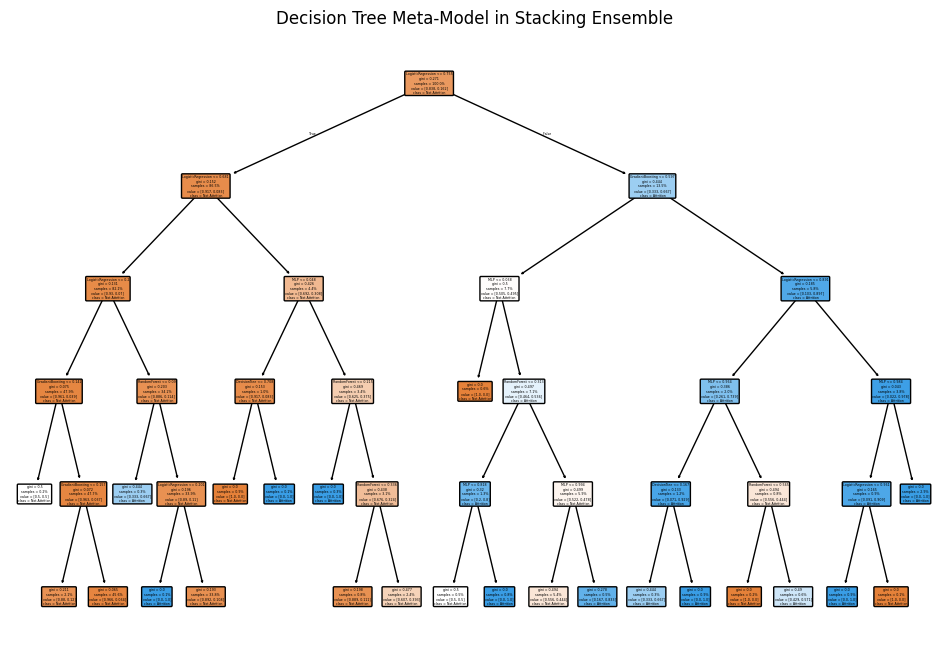

In [23]:
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# Assume best_classifier_pipelines_random is your dictionary of best base pipelines after random search tuning.
# Create a list of (name, estimator) tuples for the stacking ensemble.
estimators = [(name, pipe) for name, pipe in best_classifier_pipelines_random.items()]

# Define the meta-model (final estimator) as a Decision Tree.
meta_model = DecisionTreeClassifier(random_state=42)

# Create the stacking classifier.
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_model,
    cv=5,            # use 5-fold cross-validation to generate meta-features
    passthrough=False  # only use base predictions as input for the meta-model
)

# Define the hyperparameter grid for tuning the stacking ensemble.
# Here we tune the decision tree meta-model's parameters.
stacking_param_grid = {
    'final_estimator__max_depth': [None, 3, 5, 7],
    'final_estimator__min_samples_split': [2, 5, 10],
    'final_estimator__min_samples_leaf': [1, 2, 4],
    'passthrough': [False]  # fixed as False for simplicity
}

# Use RandomizedSearchCV for efficiency.
n_iter = 20  # adjust the number of iterations based on your computational budget

stacking_search_decision_tree = RandomizedSearchCV(
    stacking_clf,
    param_distributions=stacking_param_grid,
    n_iter=n_iter,
    cv=5,
    scoring=f2_scorer,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the stacking ensemble on the training data.
stacking_search_decision_tree.fit(X_train, y_train)

# Print the best hyperparameters and performance on the training set (via CV).
print("Best stacking parameters:")
print(stacking_search_decision_tree.best_params_)
print("Best stacking F2 Score:", stacking_search_decision_tree.best_score_)

# Evaluate the best stacking model on the test set.
stacking_test_score = stacking_search_decision_tree.best_estimator_.score(X_test, y_test)
print("Test set score (accuracy) for best stacking ensemble:", stacking_test_score)

# Visualize the meta-model (decision tree).
# The meta-model is stored in stacking_search.best_estimator_.final_estimator_
meta_tree = stacking_search_decision_tree.best_estimator_.final_estimator_

plt.figure(figsize=(12, 8))
plot_tree(meta_tree, 
          filled=True, 
          feature_names=[name for name, _ in estimators],
          class_names=['Not Attrition', 'Attrition'], 
          rounded=True, 
          proportion=True)
plt.title("Decision Tree Meta-Model in Stacking Ensemble")
plt.show()


In [24]:
import os
import joblib

# Create the models folder if it doesn't exist.
os.makedirs("models", exist_ok=True)

# Save each tuned base classifier.
for model_name, model in best_classifier_pipelines_random.items():
    filename = os.path.join("models", f"{model_name}_tuned_model.joblib")
    joblib.dump(model, filename)
    print(f"Saved {model_name} tuned model to {filename}")

# Save the stacking ensemble with logistic regression as meta-model.
# (Assuming stacking_search_logistic_regression is defined and fitted.)
stacking_lr_filename = os.path.join("models", "stacking_logistic_regression.joblib")
joblib.dump(stacking_search_logistic_regression.best_estimator_, stacking_lr_filename)
print(f"Saved stacking logistic regression ensemble to {stacking_lr_filename}")

# Save the stacking ensemble with decision tree as meta-model.
# (Assuming stacking_search_decision_tree is defined and fitted.)
stacking_dt_filename = os.path.join("models", "stacking_decision_tree.joblib")
joblib.dump(stacking_search_decision_tree.best_estimator_, stacking_dt_filename)
print(f"Saved stacking decision tree ensemble to {stacking_dt_filename}")


Saved LogisticRegression tuned model to models/LogisticRegression_tuned_model.joblib
Saved DecisionTree tuned model to models/DecisionTree_tuned_model.joblib
Saved RandomForest tuned model to models/RandomForest_tuned_model.joblib
Saved GradientBoosting tuned model to models/GradientBoosting_tuned_model.joblib
Saved MLP tuned model to models/MLP_tuned_model.joblib
Saved stacking logistic regression ensemble to models/stacking_logistic_regression.joblib
Saved stacking decision tree ensemble to models/stacking_decision_tree.joblib
